### 1. 훈련 데이터를 분류하여 복사

In [1]:
import os, shutil

In [2]:
original_dataset_path = './dogsNcats'
copy_train_path = './datasets'


In [5]:
def copy_files(dogORcat_path,start_num,end_num,trainOrval_path):
    
    image_paths = [os.path.join(original_dataset_path,"train",dogORcat_path + '.' + str(i) + '.jpg')
                  for i in range(start_num,end_num)]
    
    target_copy_paths = os.path.join(copy_train_path,trainOrval_path,dogORcat_path)
    
    if not os.path.isdir(target_copy_paths):
        os.makedirs(target_copy_paths)
        
    for image_path in image_paths:
        shutil.copy(image_path, target_copy_paths)
        
    print("데이터 복사가 완료되었습니다.")
    


In [6]:
copy_files("dog",0,10000,"train")
copy_files("cat",0,10000,"train")
copy_files("dog",10000,12500,"validation")
copy_files("cat",10000,12500,"validation")

데이터 복사가 완료되었습니다.
데이터 복사가 완료되었습니다.
데이터 복사가 완료되었습니다.
데이터 복사가 완료되었습니다.


In [8]:
print("훈련데이터 Dog 개수",len(os.listdir('./datasets/train/dog')))
print("훈련데이터 Cat 개수",len(os.listdir('./datasets/train/cat')))
print("검증데이터 Dog 개수",len(os.listdir('./datasets/validation/dog')))
print("검증데이터 Cat 개수",len(os.listdir('./datasets/validation/cat')))

훈련데이터 Dog 개수 10000
훈련데이터 Cat 개수 10000
검증데이터 Dog 개수 2500
검증데이터 Cat 개수 2500


### 2. 콜백 함수 만들기

In [10]:
from datetime import datetime
import os
import keras


Using TensorFlow backend.


In [11]:
save_dir = './my_log'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

    
project_name = 'dog_cat_CNN_model'

In [12]:
def save_file():
    time = datetime.today()
    yy = time.year
    mon = time.month
    dd = time.day
    hh = time.hour
    mm = time.minute
    sec = time.second
    time_name = str(yy) +  str(mon) + str(dd) + str(hh) + str(mm) +  str(sec) +'_my_' + project_name + '_model.h5'
    file_name = os.path.join(save_dir,time_name)
    return file_name


In [13]:
callbacks = [
    
    keras.callbacks.TensorBoard(
    log_dir = save_dir,
    write_graph=True,
    write_images=True
    ),
    
    keras.callbacks.EarlyStopping(
    monitor = 'val_acc',
        patience=10,
    ),
    keras.callbacks.ModelCheckpoint(
    filepath= save_file(),
    monitor = 'val_loss',
    save_best_only = True,
    )
]

### 3. 모델 구성

In [14]:
from keras import Input
from keras import layers ,models, losses ,optimizers

In [20]:
batch_size = 256
no_classes = 1
epochs = 50
image_height, image_width = 150,150
input_shape = (image_height,image_width,3)

In [16]:
def cnn_api(input_shape):
    
    input_tensor =Input(input_shape, name = "input")
    
    x = layers.Conv2D(filters= 32 ,kernel_size= (3,3) , padding= "same", activation='relu')(input_tensor)  
    x = layers.Conv2D(filters= 64 ,kernel_size= (3,3) , padding= "same", activation='relu')(x) 
    x = layers.Conv2D(filters= 128 ,kernel_size= (3,3) , padding= "same", activation='relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(units= 1024 , activation='relu')(x)
    
    output_tensor = layers.Dense(units= no_classes, activation= 'sigmoid', name= "output")(x)
    
    model = models.Model([input_tensor],[output_tensor])
    
    model.compile(loss = losses.binary_crossentropy, optimizer= optimizers.RMSprop(lr=0.0001), metrics=['acc'])
    return model
    

### 4. 데이터 전처리

In [17]:
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image


In [21]:
train_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255) # 검증데이터 스케일 조정만 합니다.

train_generator = train_datagen.flow_from_directory(
    os.path.join(copy_train_path,"train"),
    target_size = (image_height, image_height),
    batch_size = batch_size,
    class_mode = "binary"
    )
validation_generator = val_datagen.flow_from_directory(
    os.path.join(copy_train_path,"validation"),
    target_size = (image_height, image_height),
    batch_size = batch_size,
    class_mode = "binary"
    )

#gpu가 두개로 병렬로 각각 다른 작업을 원하시면
# with를 사용하시고 gpu:0 , gpu:1 이러게 모델을 지정하시면 됩니다. 
# from tensorflow as tf
# with tf.device('gpu:0'):
#     newType_model = cnn_api(input_shape)
    
newType_model = cnn_api(input_shape)
hist = newType_model.fit_generator(train_generator, steps_per_epoch = 20000//batch_size, epochs= epochs,
                                  validation_data = validation_generator, validation_steps = 5000//batch_size,
                                  callbacks = callbacks)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
78/78 [==============================] - 25s 319ms/step - loss: 0.8288 - acc: 0.5229 - val_loss: 0.6913 - val_acc: 0.5097
Epoch 2/50
78/78 [==============================] - 22s 279ms/step - loss: 0.6768 - acc: 0.5716 - val_loss: 0.6705 - val_acc: 0.6351
Epoch 3/50
78/78 [==============================] - 22s 283ms/step - loss: 0.6467 - acc: 0.6132 - val_loss: 0.6453 - val_acc: 0.6503
Epoch 4/50
78/78 [==============================] - 22s 283ms/step - loss: 0.6160 - acc: 0.6504 - val_loss: 0.6161 - val_acc: 0.6682
Epoch 5/50
78/78 [==============================] - 22s 283ms/step - loss: 0.5914 - acc: 0.6759 - val_loss: 0.5911 - val_acc: 0.6872
Epoch 6/50
78/7

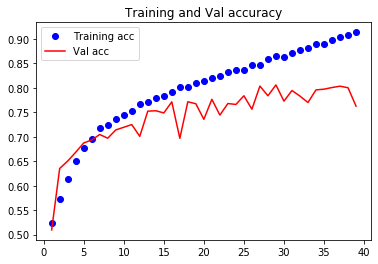

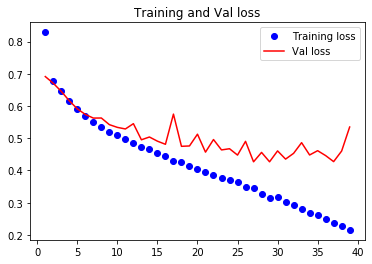

In [23]:
import matplotlib.pyplot as plt
train_acc = hist.history['acc']
val_acc = hist.history['val_acc']

train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(1,len(train_acc)+1)

plt.plot(epochs,train_acc,'bo',label='Training acc')
plt.plot(epochs,val_acc,'r',label='Val acc')
plt.title('Training and Val accuracy')
plt.legend()

plt.figure()
plt.plot(epochs,train_loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'r',label='Val loss')
plt.title('Training and Val loss')
plt.legend()

plt.show()